In [1]:
import csv
import subprocess
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import shutil

In [2]:
class Experiment:
    def __init__(self, functions_file, optimization_file, opt_folder, fig_folder):
        self.functions_file = functions_file
        self.optimization_file = optimization_file
        self.functions_param=[]
        self.optimization_param=[]
        
        
        self.f_param_list_function_id=[]
        self.f_param_list_name=[]
        self.f_param_list_range_low=[]
        self.f_param_list_range_high=[]
        self.f_param_list_dimensions_vector=[]
            
        self.opt_param_list_id = []
        self.opt_param_list_name = []
        self.opt_param_list_config_file = []
            
        self.readFunctionsFile()
        self.readOptimizationFile()
        self.opt_folder = opt_folder
        self.fig_folder = fig_folder
        self.solution_file = "solutions.csv"
        self.solution_df = None
        
        #detect os windows or linux
        if os.name == 'nt':
            # Windows
            self.exec = "../bin/release/project.exe"
        else:
            # other (linux)
            self.exec = "../bin/release/project.o"
        
    def readFunctionsFile(self):
        with open(self.functions_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.functions_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.functions_param)):
            self.f_param_list_function_id.append(self.functions_param[i][0]) #function_id
            self.f_param_list_name.append(self.functions_param[i][1]) # function name
            self.f_param_list_range_low.append(self.functions_param[i][2]) # range low
            self.f_param_list_range_high.append(self.functions_param[i][3]) # range high
            self.f_param_list_dimensions_vector.append(self.functions_param[i][4:]) # dimension vector, from 4 to the last element
            
    def readOptimizationFile(self):
        with open(self.optimization_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.optimization_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.optimization_param)):
            self.opt_param_list_id.append(self.optimization_param[i][0]) #opt algorithm id
            self.opt_param_list_name.append(self.optimization_param[i][1]) #algo name
            self.opt_param_list_config_file.append(self.optimization_param[i][2]) # config file
            
    def delete_all_output_files(self):
        files = glob.glob('a*.csv')
        for f in files:
            os.remove(f)
    def moveFileToOutFolder(self, filename):
        shutil.move(filename, self.opt_folder+filename) # move file to out folder
        
    def merge_all_output_files(self):
        files = glob.glob("a*.csv")

        #print(files)
        solutions=[]
        for f in files:
            with open(f) as csvfile:
                read_csv = csv.reader(csvfile, delimiter=',')
                for i,row in enumerate(read_csv):
                    if i != 0: # first row
                        solutions.append(row)
        #print(solutions)
        
        
        with open(self.solution_file, mode='w') as solution_file:
            writer = csv.writer(solution_file, delimiter=',', lineterminator='\n',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['algorithm_id'
                             ,'function_id'
                             ,'n_runs'
                             ,'dimensions'
                             ,'range_low'
                             ,'range_high'
                             ,'mean'
                             ,'std_dev'
                             ,'range'
                             ,'median'
                             ,'time_ms'
                             ,'range_min'
                             ,'range_max'
                            ])
            writer.writerows(solutions)
            
    def plot(self):
        df=pd.read_csv(self.opt_folder +'solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        self.solution_df = df
        
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()
        plt.title('Running time')
        plt.savefig(self.fig_folder+"running_time.png",bbox_inches='tight')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
            ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            ax1.plot(data['algorithm_id'],data['median'],label='median')
            ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            locs = [int(i) for i in self.opt_param_list_id]
            names = self.opt_param_list_name
            ax1.set_xticks(locs, minor=False)
            ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
            #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
            fig.suptitle("f%d : %s"%(id, self.f_param_list_name[id-1]), fontsize=15)
            #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
            #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax1.legend()
            ax1.set_xlabel('Algorithm')
            ax1.set_ylabel('Cost')
            ax1.grid()

            ax2.plot(data['algorithm_id'],data['time_ms'])
            ax2.set_ylabel('CPU Total Running time [ms]')
            ax2.set_xlabel('Algorithm')
            ax2.set_xticks(locs, minor=False)
            ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
            ax2.grid()
            plt.savefig(self.fig_folder + "f"+str(id)+".png",bbox_inches='tight')

        
    # run all the algorithm, 18 functions in the same time, using many CPU
    # may cause some problem with CPU clock() time... which register the cpu time of whole program
    # it seems that python is a program which call many subprocess using Popen. As a result, all the subprocess are
    # accessing to the same clock?
    def run(self, n_runs):
        
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.Popen([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            # wait every process to finish
            for p in process_list:
                p.wait()
            print("----finished----alg: %s"%self.opt_param_list_name[k])
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    # run all the algorithm in sequence one function after another only only 1 CPU
    def runOneByOne(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.run([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            print("----finished----alg: %s"%self.opt_param_list_name[k])
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    def runAllLinux(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    
                    command_str =  [self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]]
                    command_str = ' '.join(command_str)
                    os.system(command_str +' &') # execute in background

            print("----running---alg: %s"%self.opt_param_list_name[k])
            print("the files should be collected manually using collectFiles()")
        

        
    def collectFiles(self):
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
        

In [10]:
test = Experiment("../config/function_list.csv", # function config file
                  "../config/optimization_alg_list.csv", #optimization algorithm config file
                  "../out/optimization/", # output folder for the result
                  "../out/figures/" # output folder for the figures
                 ) 

In [16]:
test.run(10) # n runs in parallel (the cpu time might not be trustful)
#test.runOneByOne(1)

----finished----alg: DE_best_1_bin
----finished----alg: DE_rand_1_bin
----finished----alg: DE_randbest_1_bin
----finished----alg: DE_best_2_bin
----finished----alg: DE_rand_2_bin
----finished----alg: GA
----finished----alg: DE_best_1_exp
----finished----alg: DE_rand_1_exp
----finished----alg: DE_randbest_1_exp
----finished----alg: DE_best_2_exp
----finished----alg: DE_rand_2_exp
----finished----alg: PSO
----finished----alg: SCA
----finished----alg: BA
----finished----alg: DBA


In [102]:
#test.runAllLinux(50)

In [103]:
#test.collectFiles()

In [17]:
# Tuning
#Calibration 
df=pd.read_csv('../out/optimization/solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
#tuning function 
df_f=df[df['function_id']==1]


pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.3f}'.format
#df
df_f

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
144,0,1,10,30,-512,512.000,1266.470,272.295,849.741,1314.790,741.658,826.087,1675.830
262,1,1,10,30,-512,512.000,2766.820,361.600,1345.930,2813.310,595.215,1926.690,3272.620
212,2,1,10,30,-512,512.000,3215.190,409.691,1473.200,3110.970,597.339,2390.800,3864.000
79,3,1,10,30,-512,512.000,6448.520,328.748,1097.800,6536.450,789.450,5718.830,6816.630
41,4,1,10,30,-512,512.000,3876.070,445.582,1368.350,3766.960,794.687,3324.030,4692.390
206,5,1,10,30,-512,512.000,2025.970,186.591,493.689,2015.630,863.010,1785.590,2279.280
148,6,1,10,30,-512,512.000,2114.220,394.679,1274.000,1960.030,609.169,1682.420,2956.420
80,7,1,10,30,-512,512.000,6725.100,300.891,1037.100,6684.290,650.000,6110.220,7147.310
164,8,1,10,30,-512,512.000,6666.790,520.587,1534.120,6826.120,678.244,5814.120,7348.240
220,9,1,10,30,-512,512.000,2832.690,1333.640,4131.930,2259.070,673.060,1612.780,5744.710


pd.options.display.float_format = '{:.3f}'.format
df

plt.plot(df_f['algorithm_id'],df_f['mean'])
plt.grid()
plt.xticks(df_f['algorithm_id'])

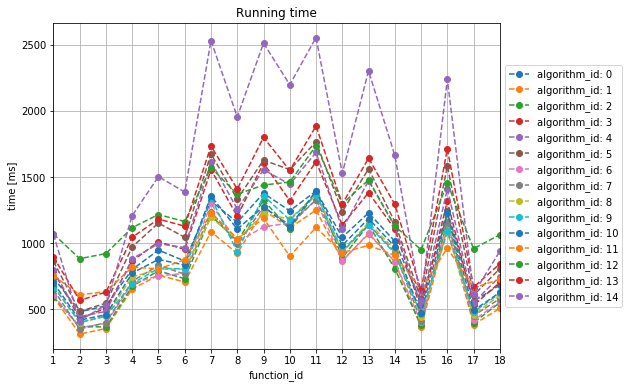

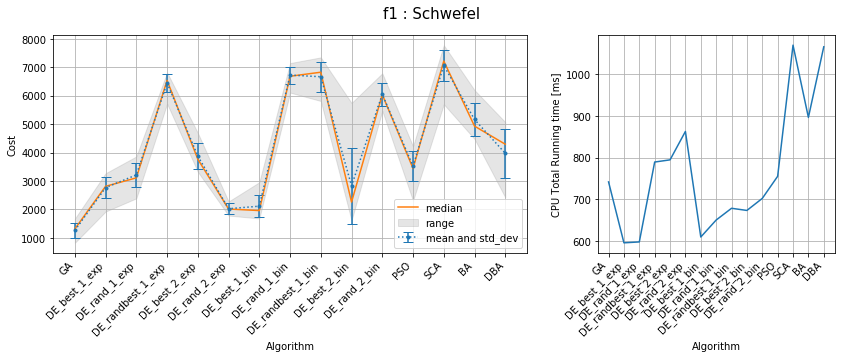

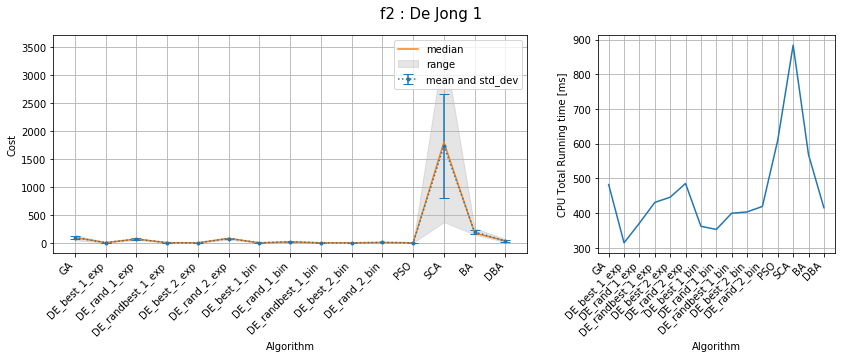

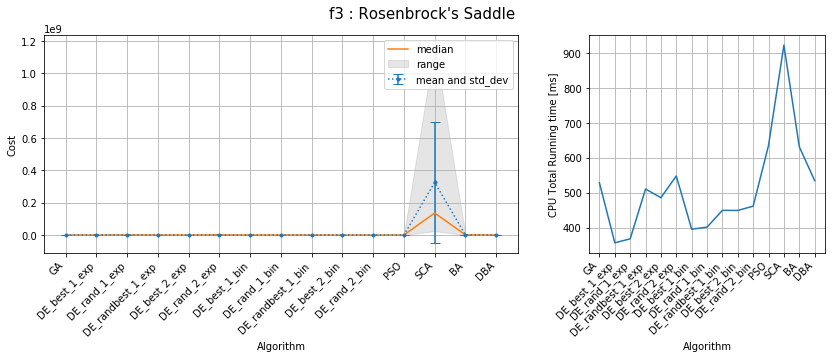

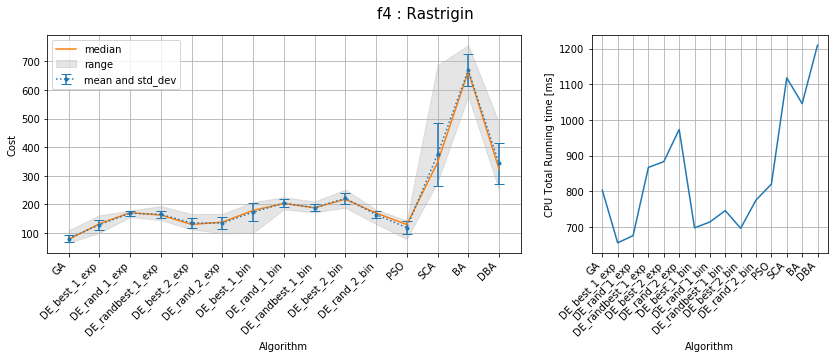

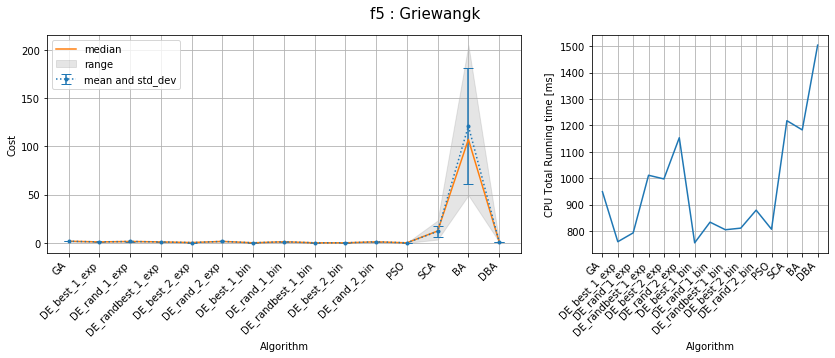

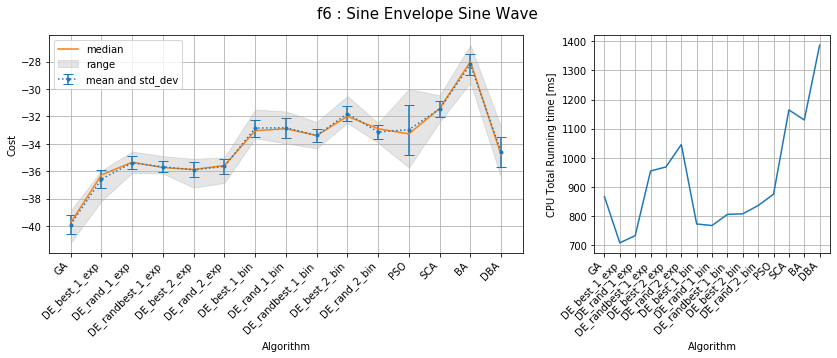

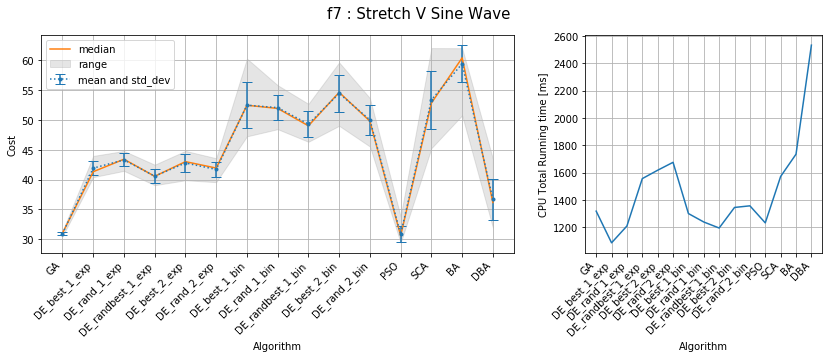

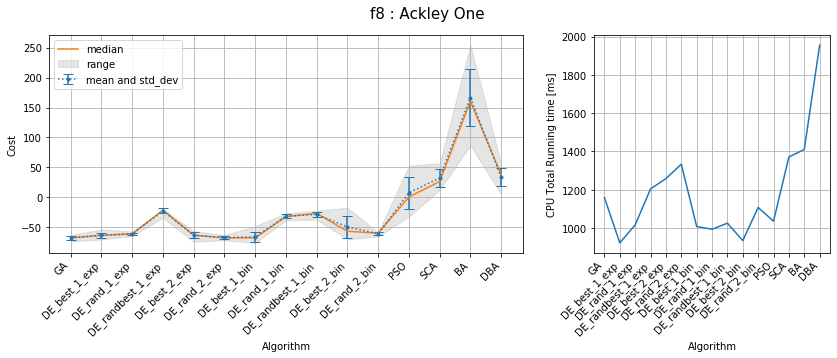

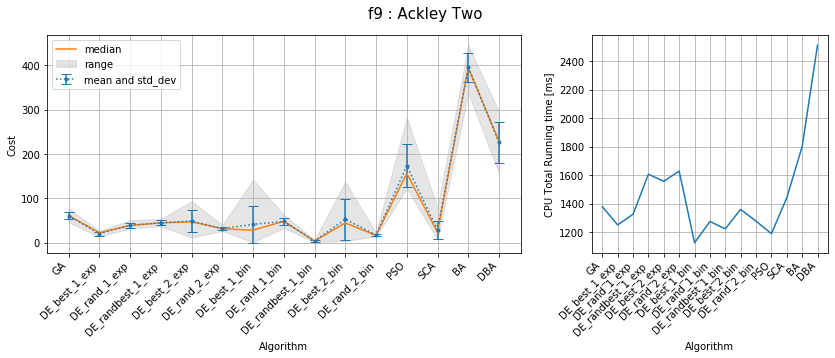

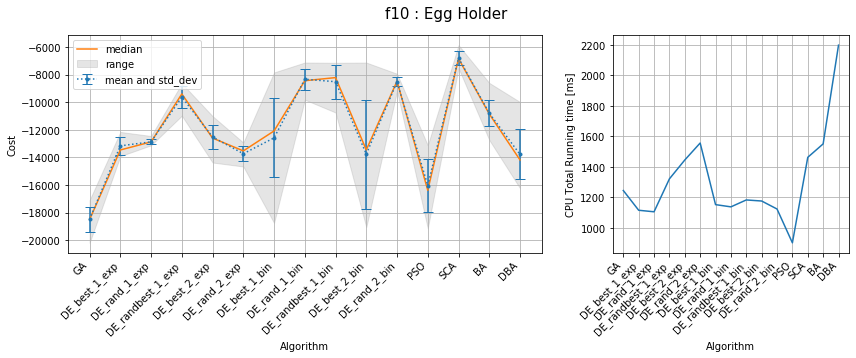

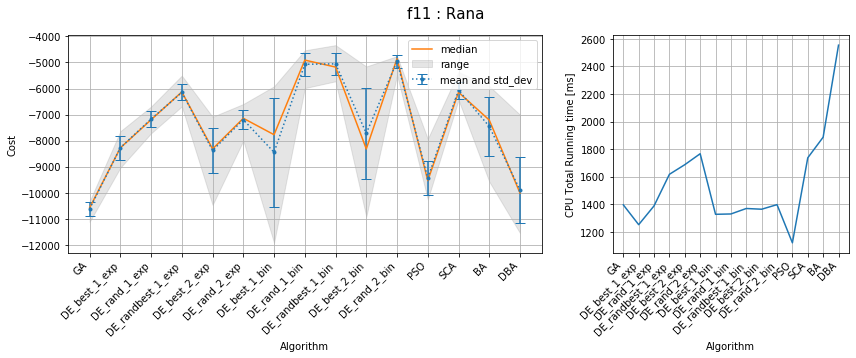

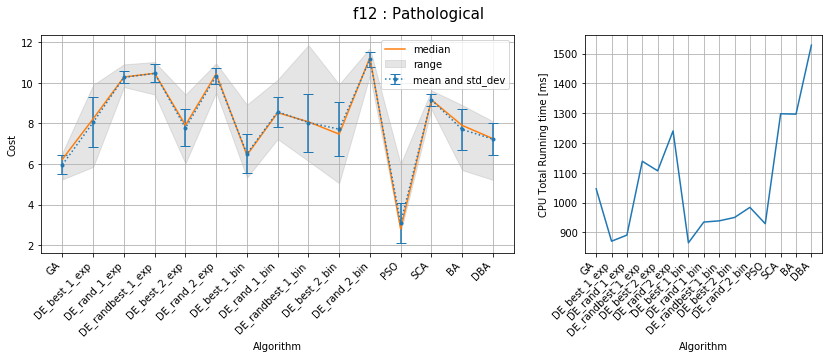

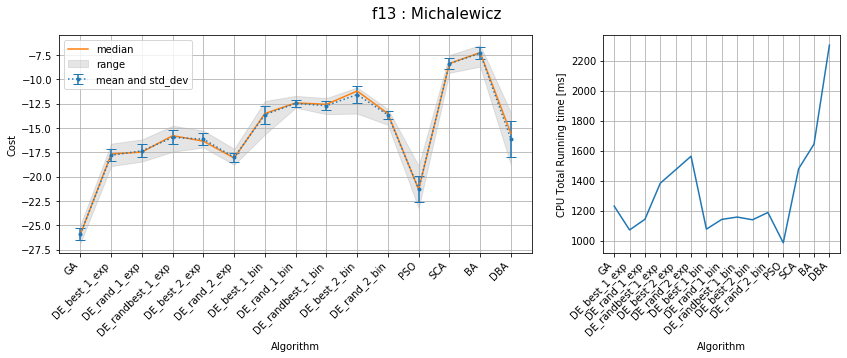

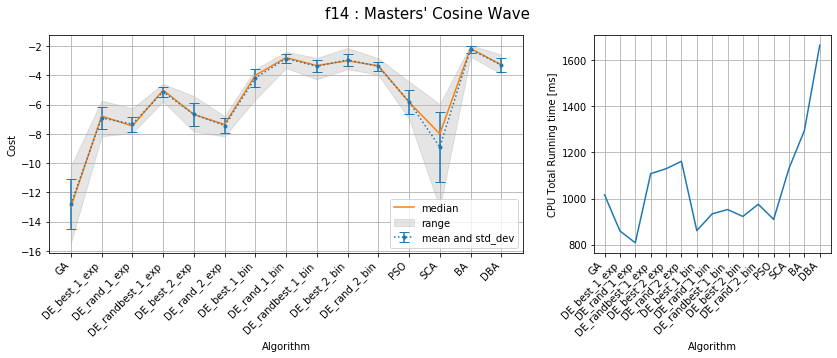

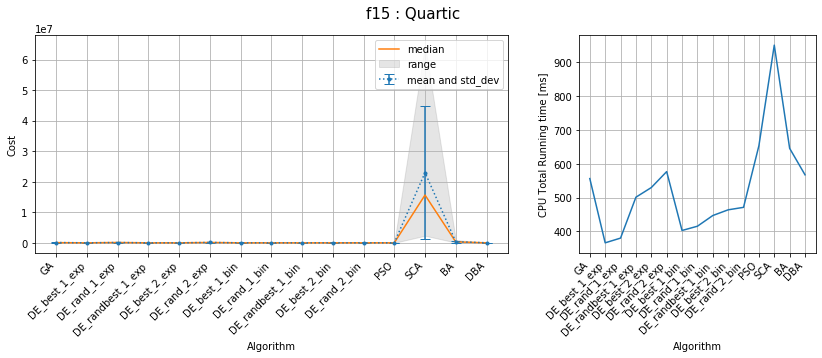

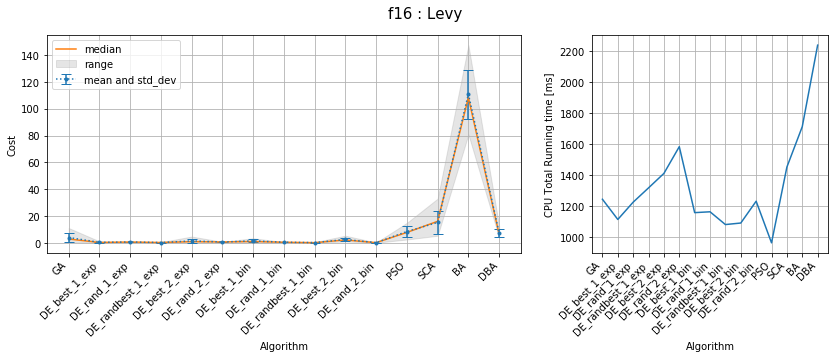

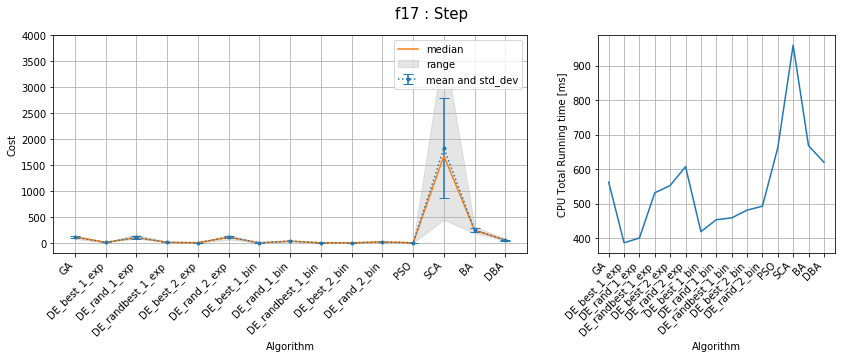

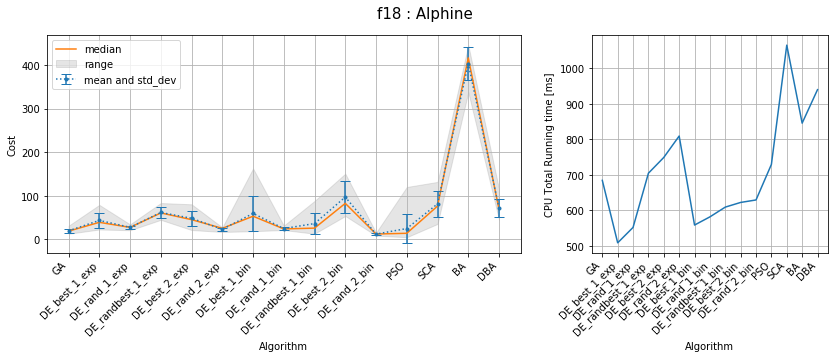

In [18]:
test.plot()

In [85]:


pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
test.solution_df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,11,1,5,30,-512,512.000,3077.600,324.860,795.904,3327.850,5306,2531.950,3327.850
10,11,2,5,30,-100,100.000,0.000,0.000,0.000,0.000,5862,0.000,0.000
11,11,3,5,30,-100,100.000,25.960,32.535,89.800,13.387,4245,0.499,90.299
12,11,4,5,30,-30,30.000,78.999,12.532,30.843,70.642,5019,66.662,97.505
13,11,5,5,30,-500,500.000,0.009,0.013,0.032,0.000,5443,0.000,0.032
14,11,6,5,30,-30,30.000,-37.520,0.854,2.567,-37.486,6591,-38.753,-36.186
15,11,7,5,30,-30,30.000,29.801,0.500,1.318,29.707,11460,29.179,30.497
16,11,8,5,30,-32,32.000,-42.713,14.867,40.775,-46.540,7013,-58.143,-17.368
17,11,9,5,30,-32,32.000,178.189,59.201,181.794,164.203,11315,101.535,283.329
1,11,10,5,30,-500,500.000,-17458.600,908.158,2610.690,-17263.600,9641,-18940.700,-16330.000


In [30]:
df = test.solution_df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,11,1,10,30,-512,512.000,3386.040,160.510,635.527,3442.600,10566,3008.070,3643.600
18,13,1,10,30,-512,512.000,3177.160,345.623,915.763,3385.230,11122,2526.840,3442.600
10,11,2,10,30,-100,100.000,0.000,0.000,0.000,0.000,6624,0.000,0.000
28,13,2,10,30,-100,100.000,0.000,0.000,0.000,0.000,7518,0.000,0.000
11,11,3,10,30,-100,100.000,100031.000,299999.000,1000020.000,17.185,6243,9.028,1000030.000
29,13,3,10,30,-100,100.000,160.894,329.478,1077.430,16.086,6688,10.267,1087.700
12,11,4,10,30,-30,30.000,83.576,17.013,54.722,82.581,15186,58.703,113.425
30,13,4,10,30,-30,30.000,90.740,26.856,90.541,96.511,10211,42.783,133.324
13,11,5,10,30,-500,500.000,0.018,0.022,0.064,0.010,10762,0.000,0.064
31,13,5,10,30,-500,500.000,0.013,0.015,0.056,0.011,12458,0.000,0.056


# Read solution.csv, generate plot and latex report

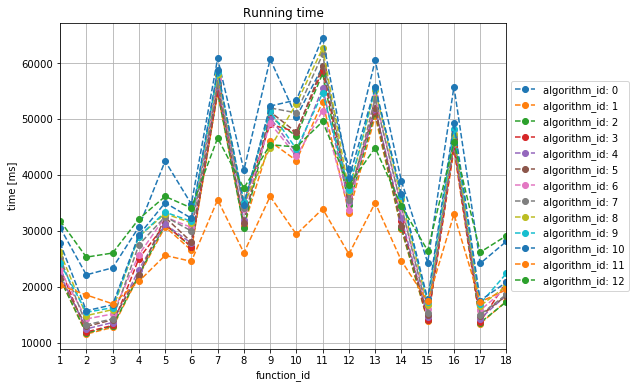

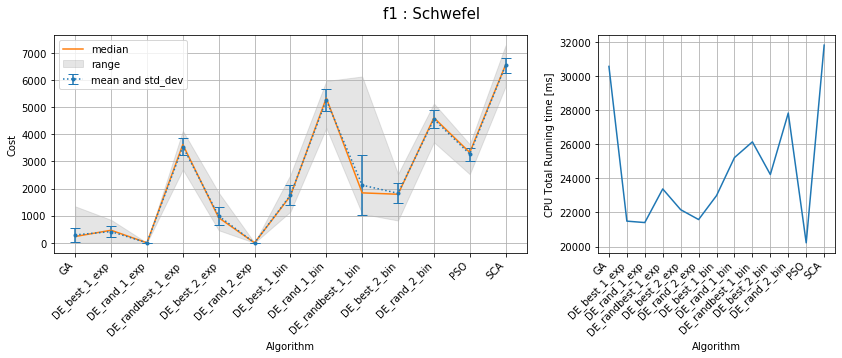

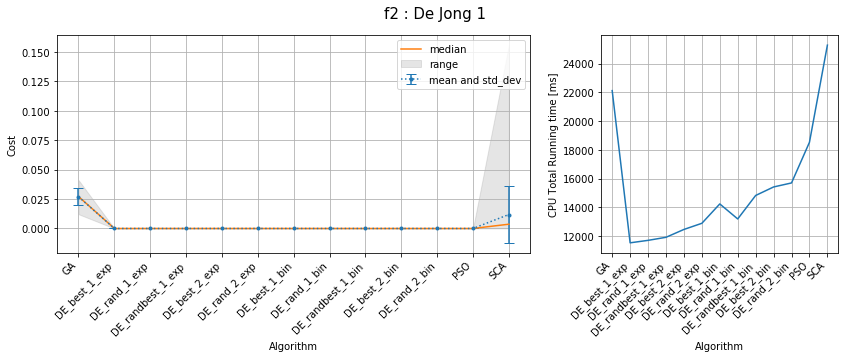

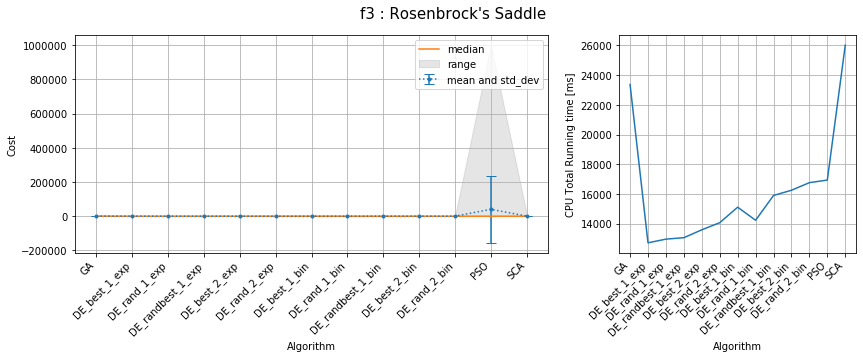

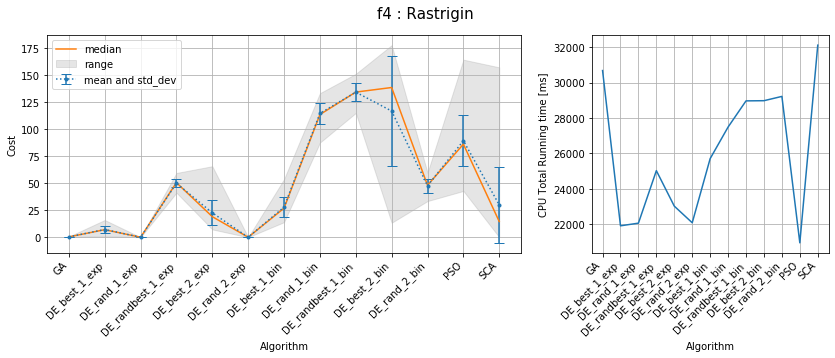

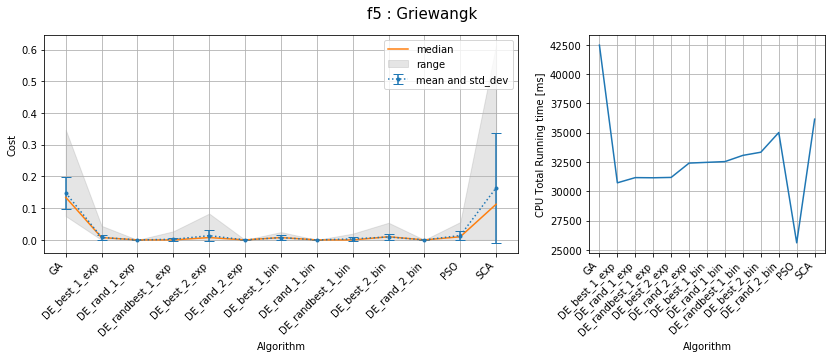

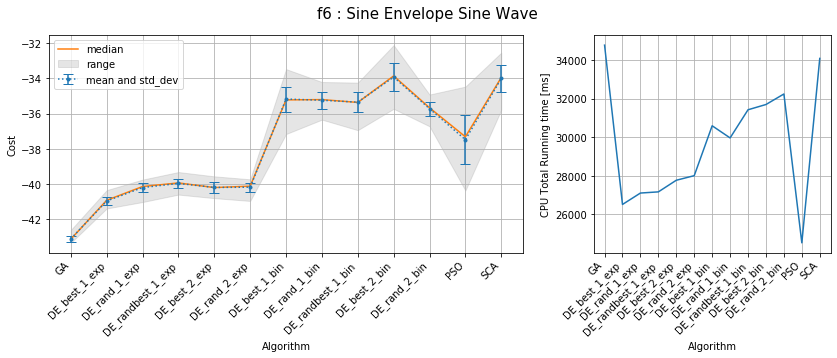

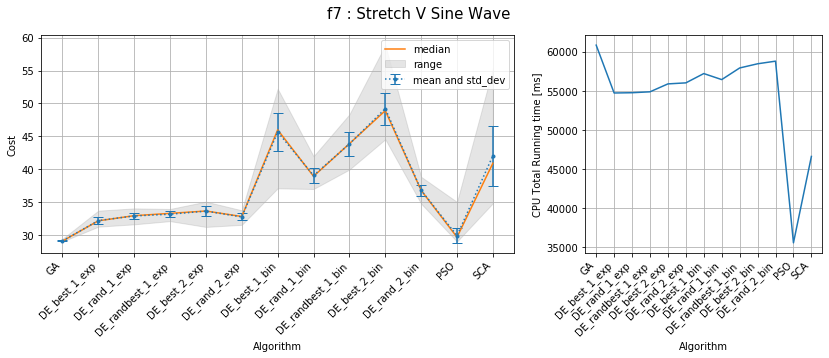

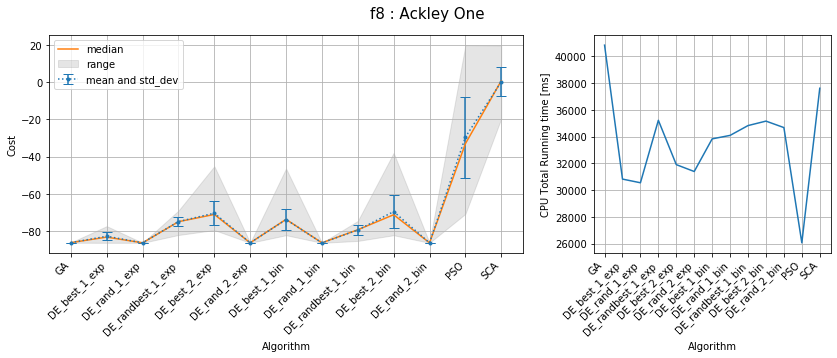

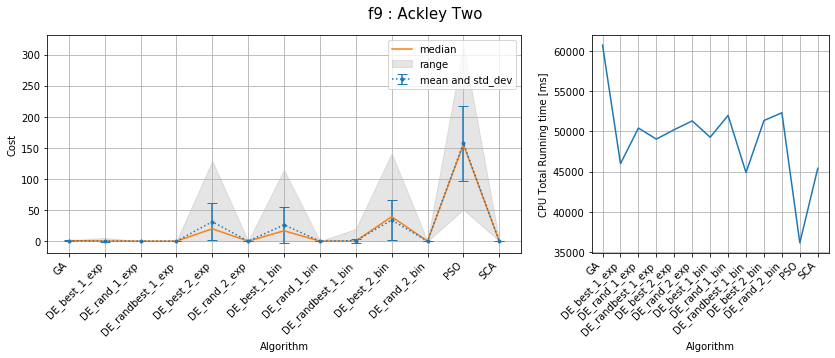

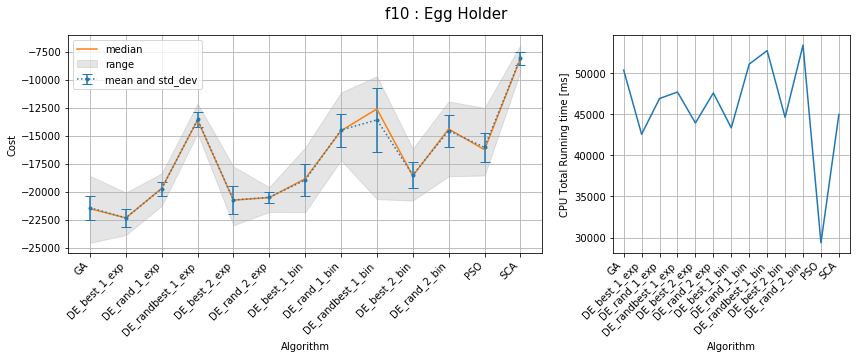

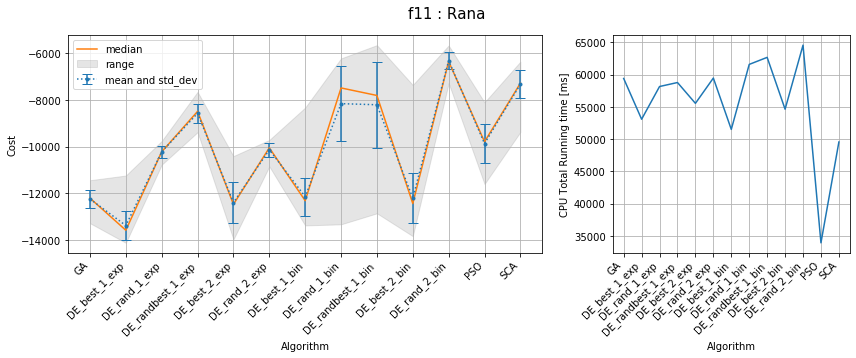

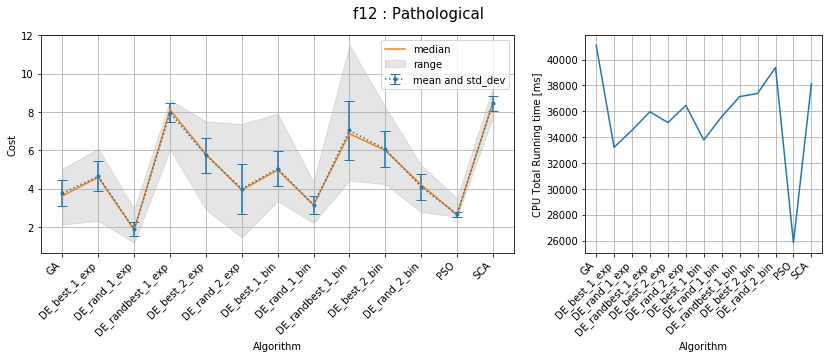

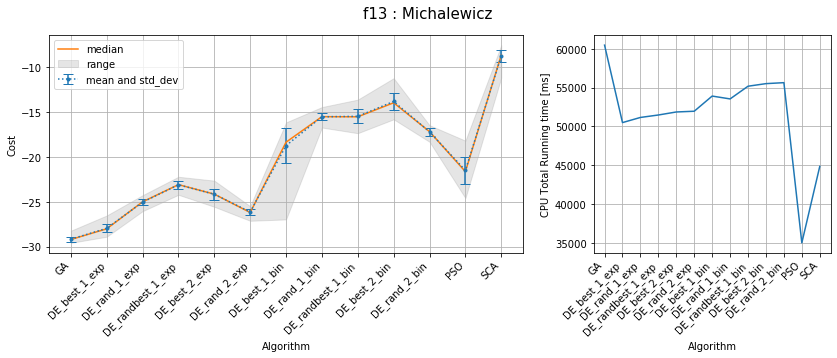

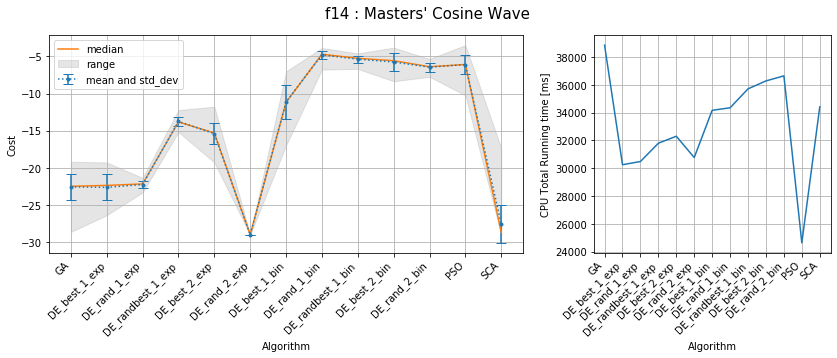

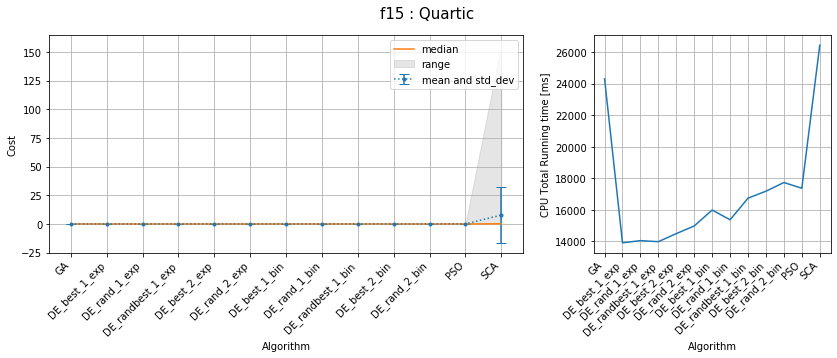

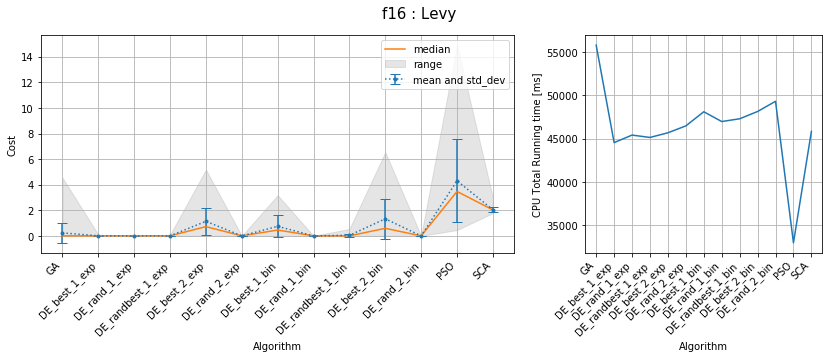

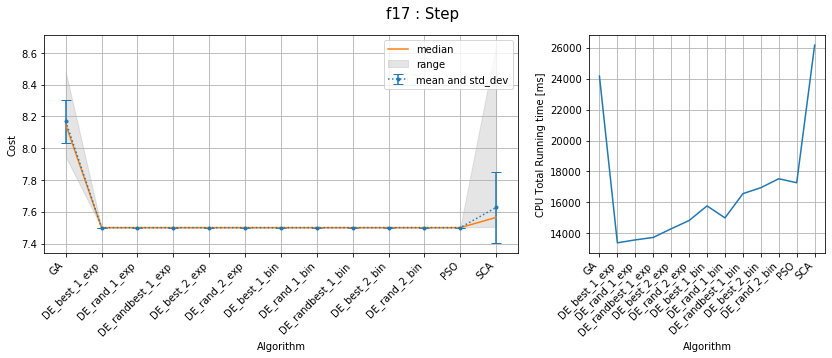

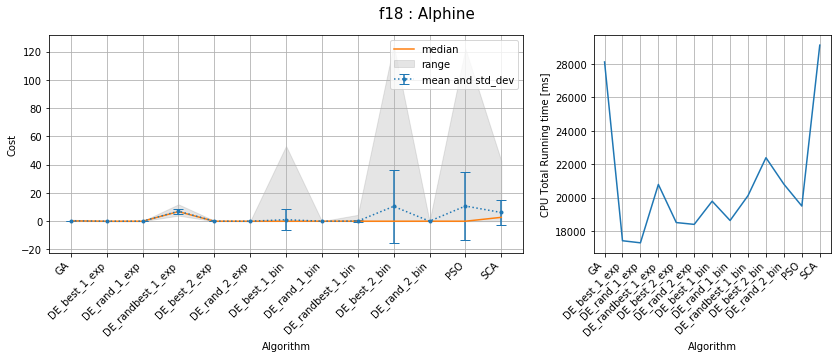

In [26]:
df=pd.read_csv("../out/optimization-linux-1cpu-500-500/"+'solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)


#-----------plot running time
fig, ax = plt.subplots(figsize=(8,6))
for label, data in df.groupby('algorithm_id'):
    data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
plt.ylabel('time [ms]')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('Running time')
#plt.savefig("running_time.png",bbox_inches='tight')


#---------plot statistics
for id, data in df.groupby('function_id'):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
    ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
    ax1.plot(data['algorithm_id'],data['median'],label='median')
    ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
    locs = [int(i) for i in test.opt_param_list_id]
    names = test.opt_param_list_name
    ax1.set_xticks(locs, minor=False)
    ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
    #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
    fig.suptitle("f%d : %s"%(id, test.f_param_list_name[id-1]), fontsize=15)
    #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.legend()
    ax1.set_xlabel('Algorithm')
    ax1.set_ylabel('Cost')
    ax1.grid()
    
    ax2.plot(data['algorithm_id'],data['time_ms'])
    ax2.set_ylabel('CPU Total Running time [ms]')
    ax2.set_xlabel('Algorithm')
    ax2.set_xticks(locs, minor=False)
    ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
    ax2.grid()
    plt.savefig("f"+str(id)+".png",bbox_inches='tight')


In [8]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
126,0,1,50,30,-512,512.000,291.715,252.889,1342.790,233.445,30556.100,0.065,1342.860
226,1,1,50,30,-512,512.000,413.589,204.703,846.204,462.697,21489.300,-0.001,846.203
183,2,1,50,30,-512,512.000,0.001,0.001,0.003,0.001,21405.800,-0.000,0.003
67,3,1,50,30,-512,512.000,3542.440,305.624,1428.860,3618.260,23376.400,2698.730,4127.590
35,4,1,50,30,-512,512.000,987.060,321.703,1386.780,925.399,22160.100,462.703,1849.480
178,5,1,50,30,-512,512.000,-0.002,0.000,0.002,-0.002,21582.000,-0.003,-0.001
130,6,1,50,30,-512,512.000,1757.670,359.702,1355.990,1728.670,22986.300,1147.530,2503.530
68,7,1,50,30,-512,512.000,5261.550,396.785,1730.240,5335.010,25214.300,4231.200,5961.440
142,8,1,50,30,-512,512.000,2124.900,1093.450,5061.780,1840.380,26134.600,1066.570,6128.350
189,9,1,50,30,-512,512.000,1824.540,364.970,1713.930,1789.090,24220.600,821.697,2535.630


## read df

In [13]:
df=pd.read_csv("../out/optimization-linux-1cpu-500-500/"+'solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)

## support codes for latex report generation

In [86]:
# https://stats.stackexchange.com/questions/124096/two-samples-z-test-in-python
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(z, 3), round(pval, 4)

z, p = twoSampZ(1330, 1350, 0, 388.5, 190.64, 50, 50)

In [87]:
df_s = df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df_s
n_sample = df_s["n_runs"].iloc[0]

# print the table and export to latex

In [88]:
def print_latex_function(function_id):
    df_fx = df_s[df_s["function_id"]==function_id] # dataframe of function_id
    
    # get name of the algorithms
    alg_id = [str(i) for i in df_fx["algorithm_id"].values.tolist()] # convert algorithm id to string
    alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
    alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
    # insert algorithms name to the dataframe
    df_fx = df_fx[["mean","std_dev","median","range_min","range_max","time_ms"]]
    df_fx.insert(0,"algorithm",alg_name)
    #display(df_fx)
    
    # get name of the functions
    f_index = test.f_param_list_function_id.index(str(function_id))
    f_name = test.f_param_list_name[f_index]
    
        
    print("\\newpage")    
    #print subsection 
    print("\\subsection{Function %d: %s}"%(function_id, f_name))
    
    
    #print function
    print("""
    \\begin{figure}[H]
    \\centering
    
    \\includegraphics[width=1\\linewidth]{{"figures/figures-linux-1cpu-500-500/f%d"}.png}
    
    \\caption{Cost and CPU total running time of Function %d: %s} 
    \\label{fig:f%d}
    \\end{figure}
    """%(function_id, function_id, f_name, function_id))


    
    # print latex table
    print("""\\begin{table}[H]
    \\centering
    \\footnotesize""")
    print(df_fx.to_latex(index=False))
    print("""\\caption{Function %d: Statistical Analysis of the Cost} 
    \\end{table}"""%function_id)
    
    
    # Hypothesis testing 
    #find the min beside GA
    #df_ga = df_fx[df_fx["algorithm"]=="GA"]
    #df_fx = df_fx[df_fx["algorithm"]!="GA"]
    min_index = df_fx[['mean']].idxmin()
    df_min = df_fx.loc[min_index] # minimun 
    x1=df_min["mean"].values[0]
    sd1=df_min["std_dev"].values[0]
    
   
    min_latex = df_min["algorithm"].values[0].replace("_","\_")
    print("Best Algorithm: \\\\")
    print("\\textbf{%s}, Cost (mean): %f\\\\"%(min_latex, x1))
        
    # save the good algorithms after the hypothesis testing
    good_alg = []
    # compare everyone with the best
    already_printed=False
    for index, row in df_fx.iterrows():
        if index != min_index.values[0]: #exclude compare with itself
  
            #get name
            current_latex = row["algorithm"].replace("_","\_")
            
            #preparing data for z-test (two sample)
            x2=row["mean"]
            sd2=row["std_dev"]

            z,p = twoSampZ(x1,x2,0,sd1,sd2,n_sample,n_sample)

            

            if(p>0.05):
                if not already_printed:
                    print("\\noindent")
                    print("\\textbf{Two-Sample Z-Test Hypothesis Testing: }")
                    print("confidence interval = 95\%\\\\")
                    print("\\vspace{-3mm}")
                    print("\\rule[3mm]{\\linewidth}{0.2pt}")
                    print("Null hypothesis: The best algorithm and the tested one are equal\\\\")
                    already_printed = True
          
                print("\\textbf{%s}, Cost (mean): %f"%(current_latex, x2))
                print(", P value: %f\\\\"%p)
                #print("\\textbf{the cost of %s is equal to the cost of %s}.\\\\"%(current_latex, min_latex))
                good_alg.append(row["algorithm"])
    
    return good_alg

print_latex_function(8)

\newpage
\subsection{Function 8: Ackley One}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures-linux-1cpu-500-500/f8"}.png}
    
    \caption{Cost and CPU total running time of Function 8: Ackley One} 
    \label{fig:f8}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
      algorithm &    mean &  std\_dev &  median &  range\_min &  range\_max &  time\_ms \\
\midrule
 PSO & -42.713 & 14.867 & -46.540 & -58.143 & -17.368 &  7013 \\
 PSO Var Weight & -56.064 & 7.068 & -57.146 & -65.008 & -47.332 &  7040 \\
\bottomrule
\end{tabular}

\caption{Function 8: Statistical Analysis of the Cost} 
    \end{table}
Best Algorithm: \\
\textbf{PSO Var Weight}, Cost (mean): -56.064000\\
\noindent
\textbf{Two-Sample Z-Test Hypothesis Testing: }
confidence interval = 95\%\\
\vspace{-3mm}
\rulem]{\linewidth}{0.2pt}
Null hypothesis: The best algorithm and the tested one are equal\\
\textbf{PSO}, Cost

['PSO']

## Print latex

In [89]:
function_list = df_s["function_id"].unique()
good_algs = []
for i in function_list:
    good_algs.append(print_latex_function(i))

\newpage
\subsection{Function 1: Schwefel}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures-linux-1cpu-500-500/f1"}.png}
    
    \caption{Cost and CPU total running time of Function 1: Schwefel} 
    \label{fig:f1}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
      algorithm &     mean &  std\_dev &   median &  range\_min &  range\_max &  time\_ms \\
\midrule
 PSO & 3077.600 & 324.860 & 3327.850 & 2531.950 & 3327.850 &  5306 \\
 PSO Var Weight & 3091.660 & 472.379 & 3327.850 & 2146.900 & 3327.850 &  5502 \\
\bottomrule
\end{tabular}

\caption{Function 1: Statistical Analysis of the Cost} 
    \end{table}
Best Algorithm: \\
\textbf{PSO}, Cost (mean): 3077.600000\\
\noindent
\textbf{Two-Sample Z-Test Hypothesis Testing: }
confidence interval = 95\%\\
\vspace{-3mm}
\rulem]{\linewidth}{0.2pt}
Null hypothesis: The best algorithm and the tested one are equal\\
\textbf{PSO Var Wei

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


## get algorithms with similar result comparing to the best

In [90]:
good_algs_s = [", ".join(i) for i in good_algs]
good_algs_s

['PSO Var Weight',
 '',
 'PSO Var Weight',
 '',
 'PSO Var Weight',
 'PSO',
 'PSO',
 'PSO',
 'PSO Var Weight',
 '',
 '',
 'PSO',
 'PSO Var Weight',
 '',
 '',
 '',
 'PSO',
 'PSO Var Weight']

In [91]:
df_similar=pd.DataFrame(list(zip(function_list,good_algs_s)), columns = ['function_id','similar_result'])

# print summary table

In [92]:
df_summary = df.sort_values(by=['algorithm_id','function_id'], inplace = False)
df_summary

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,11,1,5,30,-512,512.000,3077.600,324.860,795.904,3327.850,5306,2531.950,3327.850
10,11,2,5,30,-100,100.000,0.000,0.000,0.000,0.000,5862,0.000,0.000
11,11,3,5,30,-100,100.000,25.960,32.535,89.800,13.387,4245,0.499,90.299
12,11,4,5,30,-30,30.000,78.999,12.532,30.843,70.642,5019,66.662,97.505
13,11,5,5,30,-500,500.000,0.009,0.013,0.032,0.000,5443,0.000,0.032
14,11,6,5,30,-30,30.000,-37.520,0.854,2.567,-37.486,6591,-38.753,-36.186
15,11,7,5,30,-30,30.000,29.801,0.500,1.318,29.707,11460,29.179,30.497
16,11,8,5,30,-32,32.000,-42.713,14.867,40.775,-46.540,7013,-58.143,-17.368
17,11,9,5,30,-32,32.000,178.189,59.201,181.794,164.203,11315,101.535,283.329
1,11,10,5,30,-500,500.000,-17458.600,908.158,2610.690,-17263.600,9641,-18940.700,-16330.000


In [93]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = alg_name[alg_id.index(str(label))]
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
display(df_result)
print(df_result.to_latex(index=False))

,function_id,PSO,PSO Var Weight
0,1,3077.600,3091.660
1,2,0.000,0.000
2,3,25.960,54.770
3,4,78.999,60.294
4,5,0.009,0.010
5,6,-37.520,-37.668
6,7,29.801,29.477
7,8,-42.713,-56.064
8,9,178.189,224.763
9,10,-17458.600,-16333.700


\begin{tabular}{rrr}
\toprule
 function\_id &        PSO &  PSO Var Weight \\
\midrule
 1 & 3077.600 & 3091.660 \\
 2 & 0.000 & 0.000 \\
 3 & 25.960 & 54.770 \\
 4 & 78.999 & 60.294 \\
 5 & 0.009 & 0.010 \\
 6 & -37.520 & -37.668 \\
 7 & 29.801 & 29.477 \\
 8 & -42.713 & -56.064 \\
 9 & 178.189 & 224.763 \\
 10 & -17458.600 & -16333.700 \\
 11 & -10084.000 & -10893.700 \\
 12 & 3.712 & 2.717 \\
 13 & -22.318 & -21.311 \\
 14 & -5.740 & -7.448 \\
 15 & 0.000 & 0.000 \\
 16 & 5.630 & 1.254 \\
 17 & 7.500 & 7.500 \\
 18 & 0.215 & 8.128 \\
\bottomrule
\end{tabular}



In [94]:
df_result

,function_id,PSO,PSO Var Weight
0,1,3077.600,3091.660
1,2,0.000,0.000
2,3,25.960,54.770
3,4,78.999,60.294
4,5,0.009,0.010
5,6,-37.520,-37.668
6,7,29.801,29.477
7,8,-42.713,-56.064
8,9,178.189,224.763
9,10,-17458.600,-16333.700


## get best cost without time

In [95]:
df_best = df_result[["function_id"]]
df_best["best_algorithm"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,function_id,best_algorithm,best_cost
0,1,PSO,3077.600
1,2,PSO Var Weight,0.000
2,3,PSO,25.960
3,4,PSO Var Weight,60.294
4,5,PSO,0.009
5,6,PSO Var Weight,-37.668
6,7,PSO Var Weight,29.477
7,8,PSO Var Weight,-56.064
8,9,PSO,178.189
9,10,PSO,-17458.600


In [96]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
df_best_similar = df_best.merge(df_similar, on=["function_id"], how='left') 
df_best_similar

,function_id,best_algorithm,best_cost,similar_result
0,1,PSO,3077.600,PSO Var Weight
1,2,PSO Var Weight,0.000,
2,3,PSO,25.960,PSO Var Weight
3,4,PSO Var Weight,60.294,
4,5,PSO,0.009,PSO Var Weight
5,6,PSO Var Weight,-37.668,PSO
6,7,PSO Var Weight,29.477,PSO
7,8,PSO Var Weight,-56.064,PSO
8,9,PSO,178.189,PSO Var Weight
9,10,PSO,-17458.600,


In [25]:
print(df_best_similar.to_latex(index=False))

\begin{tabular}{rlrl}
\toprule
 function\_id & best\_algorithm &  best\_cost &                                                                                                                  similar\_result \\
\midrule
 1 &  DE\_rand\_2\_exp & -0.002 &   \\
 2 &  PSO & 0.000 &  DE\_best\_2\_exp \\
 3 &  DE\_best\_2\_bin & 6.766 &  DE\_best\_2\_exp, PSO \\
 4 &  DE\_rand\_2\_exp & 0.000 &   \\
 5 &  DE\_rand\_2\_bin & 0.000 &   \\
 6 &  GA & -43.097 &   \\
 7 &  GA & 29.109 &   \\
 8 &  DE\_rand\_1\_exp & -86.333 &  DE\_rand\_2\_exp, DE\_rand\_2\_bin \\
 9 &  DE\_rand\_2\_bin & 0.000 &  DE\_best\_1\_exp, DE\_randbest\_1\_bin \\
 10 &  DE\_best\_1\_exp & -22349.800 &   \\
 11 &  DE\_best\_1\_exp & -13371.700 &   \\
 12 &  DE\_rand\_1\_exp & 1.880 &   \\
 13 &  GA & -29.162 &   \\
 14 &  DE\_rand\_2\_exp & -28.991 &   \\
 15 &  DE\_best\_1\_bin & 0.000 &  DE\_best\_1\_exp, DE\_randbest\_1\_exp, DE\_best\_2\_exp, DE\_rand\_2\_exp, DE\_randbest\_1\_bin \\
 16 &  DE\_rand\_2\_bin & 0.000 & 

## get best cost with time

In [70]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = int(label)
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
#display(df_result)
#print(df_result.to_latex(index=False))

In [71]:
df_best = df_result[["function_id"]]
df_best["algorithm_id"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
temp = df[["algorithm_id", "function_id", "time_ms"]]
df_best = df_best.merge(temp, on=["function_id","algorithm_id"], how='left') 
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,algorithm_id,best_cost,time_ms
0,1,0,1330.170,2158.370
1,2,8,0.002,1249.120
2,3,6,520.354,1260.940
3,4,0,-67715.300,2311.080
4,5,8,0.011,2978.360
5,6,0,-40.070,2505.260
6,7,0,30.665,4661.080
7,8,0,-68.615,3126.870
8,9,8,8.953,4897.940
9,10,0,-18226.300,3839.400
